# PROSPECT model

This notebook is for testing the Disney & Lewis PROSPECT model on the Lanzhot leaf spectral data

In [1]:
%matplotlib notebook

from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


from scipy.stats import linregress
from scipy.optimize import minimize, curve_fit
from scipy.signal import savgol_filter


import matplotlib.colors as mcolors
colors = list(mcolors.TABLEAU_COLORS.keys())

#import spectralinvariant as si
from spectralinvariant.prospect import *#prospect_wavelengths
from spectralinvariant.spectralinvariants import leafalbedo_LD, lsq
wl_prospect = prospect_wavelengths()

# import pymc3 as pm
# import arviz as az
# print(f"Running on PyMC3 v{pm.__version__}")


In [2]:
def generate_spectra_LD(wl, Cab=48.6, Cw=0.0115, Cm=0.0045, Car=10.5, *args, **kwargs):
    """Generates leaf reflectance and transmittance using a given PROSPECT model
    """
    LRT = leafalbedo_LD(Cab, Cw, Cm, *args, **kwargs)
    LRT = np.interp(wl, wl_prospect, LRT)
    return LRT

def generate_spectra_Cp(wl, Cab=48.6, Cw=0.0115, Cm=0.0045, Car=10.5, N=2, *args, **kwargs):
    """Generates leaf reflectance and transmittance using a given PROSPECT model
    """
    LRT = prospect_Cp(N, Cab, Cw, Cm, *args, **kwargs)
    W = LRT[:,0]
    R = LRT[:,1]
    T = LRT[:,2]
    R = np.interp(wl, W, R)
    T = np.interp(wl, W, T)
    return R, T

def find_nearest(array, value):
    idx = (np.abs(array - value)).argmin()
    return idx

# Dry matter and water content

In [3]:
def generate_spectra_Cp(wl, Cab=48.6, Cw=0.0115, Cm=0.0045, Car=10.5, N=2, *args, **kwargs):
    """Generates leaf reflectance and transmittance using a given PROSPECT model
    """
    LRT = prospect_Cp(N, Cab, Cw, Cm, *args, **kwargs)
    W = LRT[:,0]
    R = LRT[:,1]
    T = LRT[:,2]
    R = np.interp(wl, W, R)
    T = np.interp(wl, W, T)
    return R+T#2*R#, T

def select_wls(wl, r, t, wl_a=500, wl_b=600):
    b_a = find_nearest(wl, wl_a)
    b_b = find_nearest(wl, wl_b)
    wl = wl[b_a:b_b]
    r = r[b_a:b_b]
    t = t[b_a:b_b]
    return wl, r, t


def pred_fn(u, wl, x, params):
    params[params['unknown']] = u
    kwargs = params.copy()
    kwargs.pop('unknown')

#     LRT = prospect_Cp(**kwargs)
#     R = LRT[:,1]
#     T = LRT[:,2]
#     R = np.interp(wl, wl_prospect, R)
#     T = np.interp(wl, wl_prospect, T)
#     albedo = R + T
    
    albedo = leafalbedo_LD(**kwargs)
    albedo = np.interp(wl, wl_prospect, albedo)

#     albedo = generate_spectra_Cp(wl, **kwargs)
#     albedo = generate_spectra_LD(wl, **kwargs)

    p, rho, *_ = lsq(x, albedo)
    pred = rho * albedo / (1. - p*albedo)
#     pred = albedo
    return pred


def err_fn(u, wl, x, params):
    pred = pred_fn(u, wl, x, params)
    err = pred - x
    return err.dot(err)


def buffer_fn(r, t, wl, wl_a, wl_b, params, bounds=[(0.00, 0.02)]):
    wl, r, t = select_wls(wl, r, t, wl_a, wl_b)
#     x = 2*r#r + t
    x = r + t
    pred = pred_fn(Cw, wl, x, params)
    return pred


def minimize_fn(r, t, wl, wl_a, wl_b, params, bounds=[(0.00, 0.02)], x0=0.0001):
    wl, r, t = select_wls(wl, r, t, wl_a, wl_b)
#     x = 2*r#r + t
    x = r + t
    ans = minimize(err_fn, x0=[x0], args=(wl, x, params), bounds=bounds)
    return ans



In [4]:
def pred_ac(true, model):
    n = len(true)
    err = model - true
    mse = err.dot(err) / n
    rmse = np.sqrt(mse)
    
    bias = np.sum(err) / n
    sepc = np.dot(err - bias, err - bias) / n
    sepc = np.sqrt(sepc)
    cv = 100. * sepc / np.mean(true)
    return rmse, bias, sepc, cv
    

In [5]:
fpath = Path('E:/REFORMERS/Datafiles/Lanzhot_data')

df_lop = pd.read_excel(fpath / 'LOP_biochemistry_Lanzhot_07_2019.xlsx', sheet_name='LOP')
df_bio = pd.read_excel(fpath / 'LOP_biochemistry_Lanzhot_07_2019.xlsx', sheet_name='Biochemistry')


In [39]:
df_bio = df_bio.dropna(axis=0)

#df_bio

In [40]:
colnames = df_lop.columns.values
trait_ids = df_bio.TraitID.values
tree_ids = df_bio.TreeID
cabs = df_bio["Total_chloro_ug_cm2"]
cws = df_bio["EWT - (FW-DW)/A (g/cm2)"]
cms = df_bio["LMA -(DW/A) (kg/m2)"]

# Get trait IDs of leaves that have both R and T
traits = []
for trait_id in trait_ids:
    rname = f'{trait_id}_R_A'
    tname = f'{trait_id}_T_A'
    is_in = rname in colnames and tname in colnames
    if is_in:
        traits.append(trait_id)
        
print(traits)

[112, 114, 116, 118, 120, 124, 126, 128, 130, 132, 134, 146, 152, 154, 156, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 210]


In [19]:
df_bio.columns

Index(['TreeID', 'TraitID', 'Species', 'Age', 'Location', 'Leaf size', 'Color',
       'FW', 'DW', 'Water content (%) ((FW-DW)/FW)X100', 'Leaf size- "A"',
       'SLA -(A/DW) (m2/kg)', 'LMA -(DW/A) (kg/m2)', 'EWT - (FW-DW)/A (g/cm2)',
       'Chl_a_ug_cm2', 'Chl_b_ug_cm2', 'Caro_ug_cm2', 'Total_chloro_ug_cm2',
       'Car_Chl_ratio', 'Chl_a_b_ratio'],
      dtype='object')

In [41]:
species = df_bio.Species
species_list = ["Austrian oak", "English oak", "European hornbeam", "Field maple", "Narrow-leaved ash", "Small-leaved linden", "White poplar"]


## Invert the carotenoid content

In [14]:
wla, wlb = (480, 600)
df = df_lop.loc[6:]
df = df[df.Name.between(wla, wlb)]

#print(df.Name)
wavelengths = df.Name.values.astype('float')
wavelengths

array([ 400.,  401.,  402., ..., 2498., 2499., 2500.])

In [9]:
trait = traits[0]
reflectance = df[f'{trait}_R_A'].values
transmittance = df[f'{trait}_T_A'].values


In [63]:
wla, wlb = (480, 600)
df = df_lop.loc[6:]
df = df[df.Name.between(wla, wlb)]

u = 'Car'
bounds=[(0.10, 110.05)]
x0 = 10.0001

model = np.zeros(len(traits))
true = np.zeros(len(traits))
#print(df.Name)
wavelengths = df.Name.values.astype('float')

for idx, trait in enumerate(traits):
    tree = tree_ids[trait_ids==trait].values[0]
    Cab = cabs[trait_ids==trait].values[0]
    Cw = cws[trait_ids==trait].values[0]
    Cm = cms[trait_ids==trait].values[0]
    N = 1.5
    Car = 10.
    
    reflectance = df[f'{trait}_R_A'].values
    transmittance = df[f'{trait}_T_A'].values
    albedo = reflectance + transmittance
    
    #print(tree, trait, cab, cw, cm)
    
    d = {'N': 1.5, 'Cab': cab, 'Car': Car, 'Cw': Cw, 'Cm': Cm}
    params = {'N': N, 'Cw': Cw, 'Cab': Cab, 'Car': Car, 'unknown': u, 'Cm': Cm}
    params.pop(u)
    
    ans = minimize_fn(reflectance, transmittance, wavelengths, wla, wlb, params, bounds=bounds, x0=x0)

    est = ans.x[0]
    true[idx] = Cab
    #true[idx] = d[u]
    model[idx] = est


-1.6920682437858332 3.278248527241828


<IPython.core.display.Javascript object>


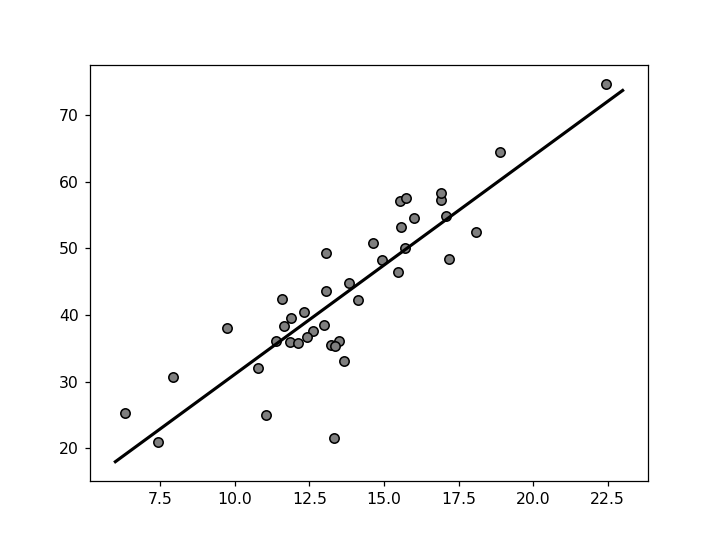

In [70]:
lrg = linregress(model, true)
print(lrg.intercept, lrg.slope)

x = np.linspace(6, 23, 100)
y = x*lrg.slope + lrg.intercept
plt.figure()
plt.scatter(model, true, edgecolor='k', c='tab:gray')
plt.plot(x, y, c='k', linewidth=2)

<IPython.core.display.Javascript object>


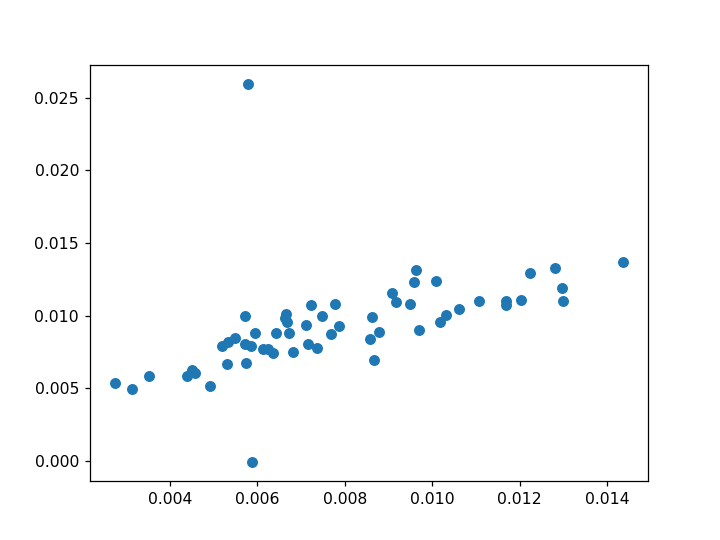

In [50]:
lrg = linregress(cabs.values, cws.values)
lrg
plt.figure()
plt.scatter(cms, cws)

# plt.figure()
# plt.scatter(cabs, cms)

In [ ]:
u = 'Car'
bounds=[(0.10, 110.05)]
x0 = 10.0001

for idx, fname in enumerate(fnames_spectra):
    LRT = np.loadtxt(fname_spectra)
    WL = LRT[:,0]
    R = LRT[:,1]
    T = LRT[:,2]

    N, Cab, Car, Cw, Cm = (2, 40, 10, 0.015, 0.0045)
    Cab = true[idx]
    print(Cab)
    d = {'N': N, 'Cab': Cab, 'Car': Car, 'Cw': Cw, 'Cm': Cm}
    params = {'N': N, 'Cw': Cw, 'Cab': Cab, 'Car': Car, 'unknown': u, 'Cm': Cm}
    params.pop(u)
#     print(params)
    
    ans = minimize_fn(R, T, WL, wla, wlb, params, bounds=bounds, x0=x0)

    est = ans.x[0]
    #true[idx] = d[u]
    model[idx] = est


In [14]:
wla, wlb = (480, 600)
df = df_lop.loc[6:]
df = df[df.Name.between(wla, wlb)]

#print(df.Name)
wavelengths = df.Name.values.astype('float')
wavelengths

array([ 400.,  401.,  402., ..., 2498., 2499., 2500.])

In [9]:
trait = traits[0]
reflectance = df[f'{trait}_R_A'].values
transmittance = df[f'{trait}_T_A'].values


In [27]:
tree = tree_ids[trait_ids==trait].values[0]

tree

15

In [35]:
cab = cabs[trait_ids==trait].values[0]
cab

57.21

In [ ]:
chlorophyll_ids = df_bio

<IPython.core.display.Javascript object>


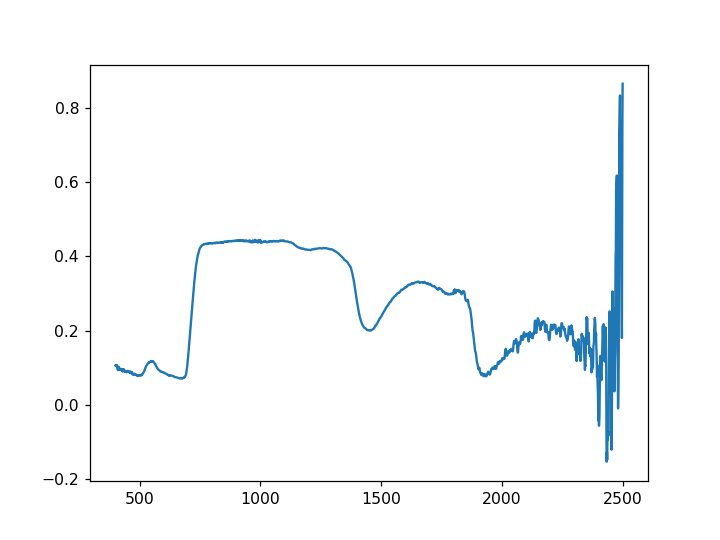

In [12]:
plt.figure()
plt.plot(wavelengths, reflectance)

In [11]:
wavelengths

array([400, 401, 402, ..., 2498, 2499, 2500], dtype=object)

In [8]:
fpath = Path('E:/REFORMERS/Datafiles/Lanzhot_data')

treeid = 6
fname = fpath / f'single_trees/carpinus_{treeid}.tif'
# treeid = 8
# fname = fpath / f'single_trees/fraxinus_{treeid}.tif'

print(fname.exists())


True


<IPython.core.display.Javascript object>


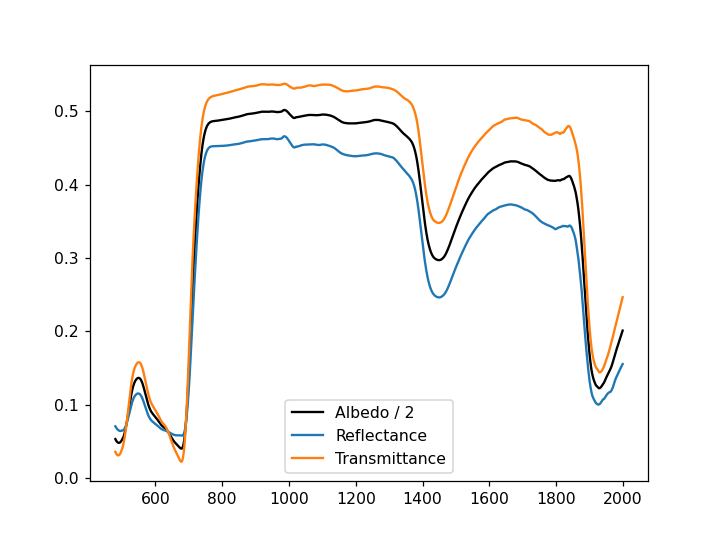

In [45]:
p_spectra = (fpath / 'single_trees/spectra')
fnames_spectra = list(p_spectra.glob(f'*_{treeid}.csv'))
# for _ in fnames_spectra:
#     print(_)
    
idx = 3
fname_spectra = fnames_spectra[idx]

LRT = np.loadtxt(fname_spectra)
WL = LRT[:,0]
R = LRT[:,1]
T = LRT[:,2]


#wla, wlb = (1005, 1300)
wla, wlb = (480, 2000)

ba = find_nearest(WL, wla)
bb = find_nearest(WL, wlb)
WL = WL[ba:bb]
R = R[ba:bb]
T = T[ba:bb]

smooth = True
if smooth:
    R = savgol_filter(R, 41, 2)
    T = savgol_filter(T, 41, 2)


A = R + T

plt.figure()
plt.plot(WL, A/2, c='k', label='Albedo / 2')
plt.plot(WL, R, label='Reflectance')
plt.plot(WL, T, label='Transmittance')
plt.legend()

In [65]:
true = np.array([43.57,
                52.46,
                32.05,
                25.34,
                36.63])

true

array([43.57, 52.46, 32.05, 25.34, 36.63])

In [66]:
model = np.zeros(len(fnames_spectra))

wl_a, wl_b = (400, 590)
u = 'Car'
bounds=[(0.10, 110.05)]
x0 = 10.0001

for idx, fname in enumerate(fnames_spectra):
    LRT = np.loadtxt(fname_spectra)
    WL = LRT[:,0]
    R = LRT[:,1]
    T = LRT[:,2]

    N, Cab, Car, Cw, Cm = (2, 40, 10, 0.015, 0.0045)
    Cab = true[idx]
    print(Cab)
    d = {'N': N, 'Cab': Cab, 'Car': Car, 'Cw': Cw, 'Cm': Cm}
    params = {'N': N, 'Cw': Cw, 'Cab': Cab, 'Car': Car, 'unknown': u, 'Cm': Cm}
    params.pop(u)
#     print(params)
    
    ans = minimize_fn(R, T, WL, wla, wlb, params, bounds=bounds, x0=x0)

    est = ans.x[0]
    #true[idx] = d[u]
    model[idx] = est


43.57
52.46
32.05
25.34
36.63


2.281323525440655 3.5737702143361663


<IPython.core.display.Javascript object>


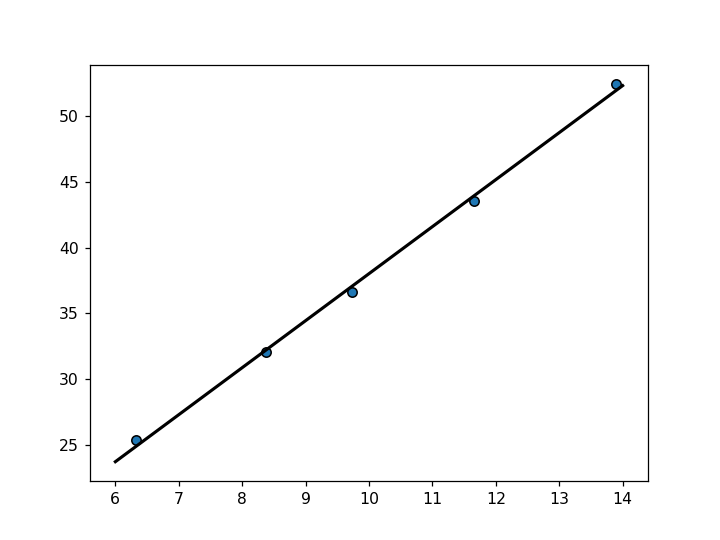

In [72]:
lrg = linregress(model, true)
print(lrg.intercept, lrg.slope)

x = np.linspace(6, 14, 100)
y = x*lrg.slope + lrg.intercept
plt.figure()
plt.scatter(model, true, edgecolor='k')
plt.plot(x, y, c='k', linewidth=2)

In [6]:
fpath_angers = Path('E:\REFORMERS\Datafiles\Angers2003')
fname_angers = fpath_angers / 'LDB_angers2003.xls'

fpath_lopex = Path('E:\REFORMERS\Datafiles\LOPEX1993')
fname_lopex = fpath_lopex / 'LDB_lopex1993.xls'

df_angers = pd.read_excel(fname_angers, sheet_name='Database')
indices_angers = df_angers.index.values

df_lopex = pd.read_excel(fname_lopex, sheet_name='Database')
indices_lopex = df_lopex.index.values

df_angers.head()

,English Name,Latin Name,Refl_file,Trans_file,Plant Type,N,C_a,C_b,C_ab,C_car,C_anth,EWT,LMA,SPAD,T660,T720,T840,T940,T1300
0,Sycamore maple,Acer pseudoplatanus L.,1,1,2,1.313594,9.526932,3.013850,12.540782,4.33,-999,0.012223,0.005507,18.6375,0.082063,0.233124,0.342019,0.340148,0.258489
1,Sycamore maple,Acer pseudoplatanus L.,2,2,2,1.425785,9.005425,3.408264,12.413689,3.65,-999,0.012000,0.005252,19.1500,0.090501,0.247603,0.352357,0.347906,0.267809
2,Sycamore maple,Acer pseudoplatanus L.,3,3,2,1.549407,19.363700,6.450325,25.814022,6.50,-999,0.010600,0.004456,30.8125,0.051558,0.274483,0.420927,0.423752,0.336191
3,Sycamore maple,Acer pseudoplatanus L.,4,4,2,1.652313,18.663168,5.471817,24.134988,6.90,-999,0.010854,0.004329,30.4625,0.044840,0.222036,0.369032,0.364431,0.277155
4,Sycamore maple,Acer pseudoplatanus L.,5,5,2,1.437254,12.157069,4.964505,17.121578,4.91,-999,0.010377,0.004011,21.8750,0.070874,0.241489,0.335033,0.340661,0.258644


In [7]:
df_lopex['EWT'].max()

0.052487804878048785

In [8]:
df_lopex.head()

,English Name,Latin Name,Refl_file,Trans_file,Plant Type,N,C_a,C_b,C_ab,C_car,...,C_O,C_N,C_prot1,C_prot2,C_cell1,C_cell2,C_lign1,C_lign2,C_star1,C_star2
0,Red clover,Trifolium pratense L.,1,1,2,1.696103,33.109649,11.5621,44.671748,6.337514,...,37.39,5.14,31.69,31.35,12.1,15.78,3.04,2.16,0.0,2.43
1,NaN,NaN,2,2,2,1.635764,33.109649,11.5621,44.671748,6.337514,...,37.39,5.14,31.69,31.35,12.1,15.78,3.04,2.16,0.0,2.43
2,NaN,NaN,3,3,2,1.600121,33.109649,11.5621,44.671748,6.337514,...,37.39,5.14,31.69,31.35,12.1,15.78,3.04,2.16,0.0,2.43
3,NaN,NaN,4,4,2,2.194581,33.109649,11.5621,44.671748,6.337514,...,37.39,5.14,31.69,31.35,12.1,15.78,3.04,2.16,0.0,2.43
4,NaN,NaN,5,5,2,1.893365,33.109649,11.5621,44.671748,6.337514,...,37.39,5.14,31.69,31.35,12.1,15.78,3.04,2.16,0.0,2.43


In [9]:
dname = 'angers'
if dname == 'lopex':
    df = df_lopex
    fpath = fpath_lopex
    indices = indices_lopex
    
elif dname == 'angers':
    df = df_angers
    fpath = fpath_angers
    indices = indices_angers
else:
    raise Exception('dname must be either lopex or angers')

<IPython.core.display.Javascript object>


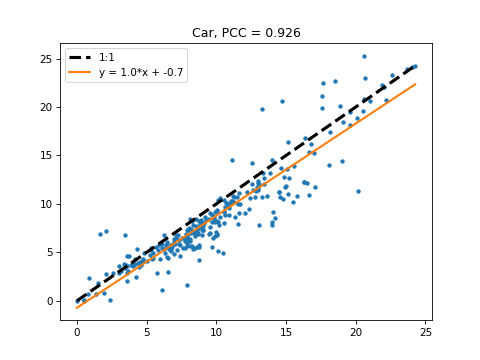

In [11]:
good = np.where(true!=-999)
model = model[good]
true = true[good]

lrg = linregress(model, true)
xx = np.linspace(0, model.max(), 100)
yy = xx*lrg.slope + lrg.intercept


plt.figure()
plt.title(f'{u}, PCC = {lrg.rvalue:.3f}')

plt.scatter(model, true, s=10)
plt.plot([0, model.max()], [0, model.max()], c='k', linewidth=3, linestyle='--', label='1:1')
plt.plot(xx, yy, c='tab:orange', linewidth=2, label=f'y = {lrg.slope:.1f}*x + {lrg.intercept:.1f}')
plt.legend()

In [13]:
rmse, bias, sepc, cv = pred_ac(true, model)

print(f'RMSEP = {rmse:.4f}, BIAS = {bias:.5f}, SEPC = {sepc:.4f}, CV = {cv:.2f} %')



RMSEP = 2.2711, BIAS = 1.20736, SEPC = 1.9236, CV = 22.21 %


In [18]:
df_lopex.LMA.max()

0.01573170731707317

## Plot leaf PROSPECT spectra with different parameters

<IPython.core.display.Javascript object>


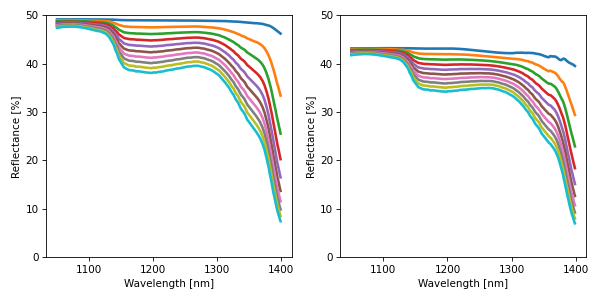

0.030677417922578276 0.7285238026189
0.043751559677012754 0.7123480874343834


<IPython.core.display.Javascript object>


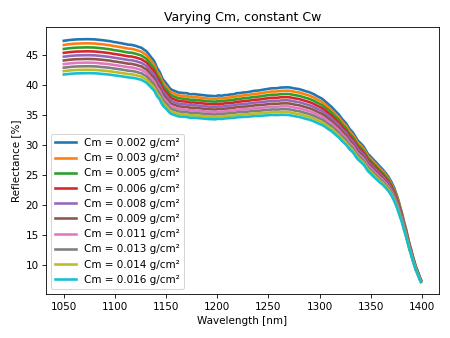

Text(0.5, 1.0, 'Varying Cm, constant Cw')

In [40]:
wl_a, wl_b = (1050, 1400)
WL = np.arange(wl_a, wl_b)


A = leafalbedo_LD(Cab, Cw, Cm)#, Cp=0.00096)
A = np.interp(WL, wl_prospect, A)
#plt.plot(WL, A, c='k')
n = 10
NDI = np.zeros(n)

variables = np.linspace(0.0009, 0.053, n)

fig = plt.figure(figsize=(8,4), tight_layout=True)
ax = fig.add_subplot(121)
for idx, var in enumerate(variables):
    A = leafalbedo_LD(Cab, var, df_lopex.LMA.min())#, Cp=0.00096)
    A = np.interp(WL, wl_prospect, A)
    NDI[idx] = (A[0] - A[-1]) / (A[0] + A[-1])
    ax.plot(WL, A*50, linewidth=2.5, label=f'Cw = {var:.3f} g/cm²')
# ax.legend()
ax.set_xlabel('Wavelength [nm]')
ax.set_ylabel('Reflectance [%]')
ax.set_ylim([0, 50])

print(NDI[0], NDI[-1])

ax = fig.add_subplot(122)
for idx, var in enumerate(variables):
    A = leafalbedo_LD(Cab, var, df_lopex.LMA.max())#, Cp=0.00096)
    A = np.interp(WL, wl_prospect, A)
    NDI[idx] = (A[0] - A[-1]) / (A[0] + A[-1])
    ax.plot(WL, A*50, linewidth=2.5, label=f'Cw = {var:.3f} g/cm²')
# ax.legend()
ax.set_xlabel('Wavelength [nm]')
ax.set_ylabel('Reflectance [%]')
ax.set_ylim([0, 50])
print(NDI[0], NDI[-1])

# plt.title('Varying Cw, constant Cm')
# plt.savefig('water_content.pdf', format='pdf')


fig = plt.figure(figsize=(6,4.5), tight_layout=True)
A = leafalbedo_LD(Cab, Cw, Cm)#, Cp=0.00096)
A = np.interp(WL, wl_prospect, A)
#plt.plot(WL, A, c='k')

vars = np.linspace(0.0017, 0.0157, 10)
for var in vars:
    A = leafalbedo_LD(Cab, df_lopex.EWT.max(), var)#, Cp=0.00096)
    A = np.interp(WL, wl_prospect, A)
    plt.plot(WL, A*50, linewidth=2.5, label=f'Cm = {var:.3f} g/cm²')
plt.legend()
plt.xlabel('Wavelength [nm]')
plt.ylabel('Reflectance [%]')
plt.title('Varying Cm, constant Cw')



# plt.savefig('dry_matter_content.png', format='png')
    
# plt.figure()
# # A = leafalbedo_LD(Cab, Cw, Cm, Cp=0.00096)
# # A = np.interp(WL, wl_prospect, A)
# #plt.plot(WL, A, c='k')

# vars = np.linspace(0.0001, 0.001, 10)
# for var in vars:
#     A = leafalbedo_LD(Cab, Cw, Cm, Cp=var)
#     A = np.interp(WL, wl_prospect, A)
#     plt.plot(WL, A)


In [21]:
df_lopex.EWT.min(), df_lopex.EWT.max()

(0.00029268292682926866, 0.052487804878048785)

In [22]:
def ndi(x=None, wl_a=1100, wl_b=1330, Cm=0.0045):
    if x is None:
        x = np.linspace(0.0009, 0.053, 100)

    WL = np.arange(wl_a, wl_b)
    NDI = np.zeros(len(x))

    
    for idx, var in enumerate(x):
        A = leafalbedo_LD(Cab, var, Cm)#, Cp=0.00096)
        A = np.interp(WL, wl_prospect, A)
        NDI[idx] = (A[0] - A[-1]) / (A[0] + A[-1])
    return x, NDI

<IPython.core.display.Javascript object>


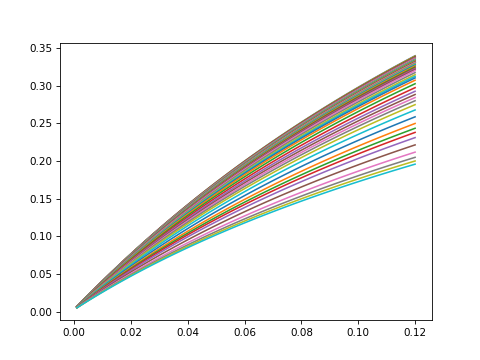

In [63]:
plt.figure()

for i in range(1100, 1150):
    plt.plot(*ndi(wl_a=i))


In [77]:
wl_as = range(1100, 1150)
wl_bs = np.flip(np.arange(1270, 1340))
N = len(wl_as)
M = len(wl_bs)
pcc = np.zeros((N, M))

for i, a in enumerate(wl_as):
    for j, b in enumerate(wl_bs):
        X, NDI = ndi(wl_a=a, wl_b=b)
        lrg = linregress(X, NDI)
        pcc[i,j] = lrg.rvalue

<IPython.core.display.Javascript object>


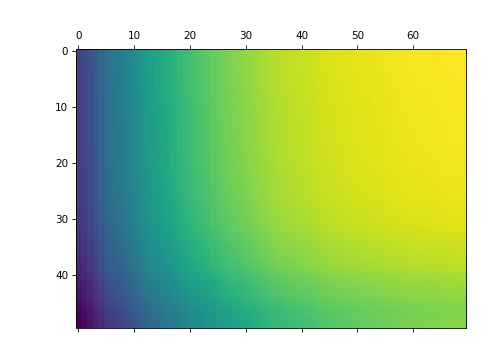

In [78]:
plt.matshow(pcc)

<IPython.core.display.Javascript object>


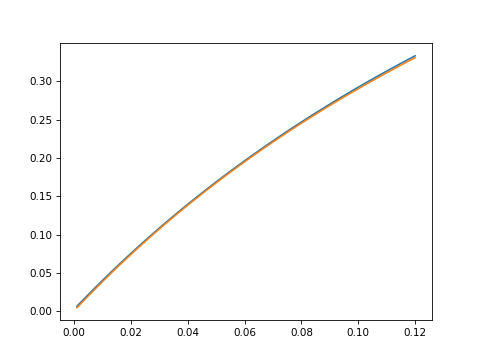

In [67]:
print()
#NDI = ndi(b1=find_nearest())
plt.figure()
plt.plot(*ndi(wl_a=1110))
plt.plot(*ndi(wl_a=1120, Cm=0.001))


In [52]:
linregress(ndi()[0], ndi()[1])

LinregressResult(slope=2.2482504037606486, intercept=0.016534521151913006, rvalue=0.9969562429900071, pvalue=2.049577507901212e-110, stderr=0.017760075542769312, intercept_stderr=0.0012386520705941382)

In [18]:
find_nearest(WL, 1330)

209

<IPython.core.display.Javascript object>


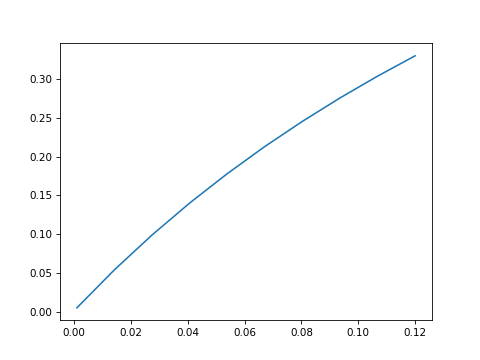

In [41]:
plt.figure()
plt.plot(variables, NDI)

In [15]:
linregress(variables, NDI)

LinregressResult(slope=2.7051274325205834, intercept=0.020637784272286186, rvalue=0.9951095837193198, pvalue=2.487771150978256e-09, stderr=0.09493538542328302, intercept_stderr=0.006781453324755271)

# Invert Cab and Car at the same time

In [55]:
def pred_fn(u, wl, x, params):
    params[params['unknown']] = u
    kwargs = params.copy()
    kwargs.pop('unknown')
    
    albedo = leafalbedo_LD(**kwargs)
    albedo = np.interp(wl, wl_prospect, albedo)

    p, rho, *_ = lsq(x, albedo)
    pred = rho * albedo / (1. - p*albedo)
    return pred


def err_fn(u, wl, x, params):
    pred = pred_fn(u, wl, x, params)
    err = pred - x
    return err.dot(err)



def minimize_fn(r, t, wl, wl_a, wl_b, params, bounds=[(0.00, 0.02)], x0=0.0001):
    wl, r, t = select_wls(wl, r, t, wl_a, wl_b)
    x = r + t
    ans = minimize(err_fn, x0=[x0], args=(wl, x, params), bounds=bounds)
    return ans



In [1790]:
idx=2

bounds=[(0.7, 120.05)]

u = 'Car'
wl_a, wl_b = (480, 590)

wavelengths, r, t = load_spectra(fpath, df, idx, dname=dname)
N, Ca, Cb, Cab, Car, Cw, Cm  = get_leaf_params(df, idx)
d = {'N': N, 'Cab': Cab, 'Car': Car, 'Cw': Cw, 'Cm': Cm}

Cab0 = 9.34
Car0 = Cab0/4

print(f'True values:\t Cab = {Cab:.2f}\t Car = {Car:.2f}')
print(f'Initial values:\t Cab = {Cab0:.2f}\t Car = {Car0:.2f}')
print(err_fn(Cab, wavelengths, r+t, params))
errors = []

Cab_ = Cab0
Car_ = Car0

step = 1.0

True values:	 Cab = 25.81	 Car = 6.50
Initial values:	 Cab = 9.34	 Car = 2.33
1.593887879722102


In [1883]:
Cab_ = Cab0
Car_ = Car0

# Initial error
u = 'Cab'
params0 = {'N': N, 'Cw': Cw, 'Cab': Cab_, 'Car': Car_, 'unknown': u, 'Cm': Cm}
params0.pop(u)
error0 = err_fn(Cab_, wavelengths, r+t, params0)


### Invert Car first using Cab0, Car0
u = 'Car'
params = {'N': N, 'Cw': Cw, 'Cab': Cab_, 'Car': Car_, 'unknown': u, 'Cm': Cm}
params.pop(u)
ans = minimize_fn(r, t, wavelengths, wl_a, wl_b, params, bounds=bounds, x0=Cab_)
Car_ = ans.x[0]
# Car0 = ans.x[0]
# error0 = err_fn(Cab0, wavelengths, r+t, params)
# print(f'Car { Car_:.4f}', Car)

### Invert Cab using 
u = 'Cab'
params = {'N': N, 'Cw': Cw, 'Cab': Cab_, 'Car': Car_, 'unknown': u, 'Cm': Cm}
params.pop(u)
ans = minimize_fn(r, t, wavelengths, wl_a, wl_b, params, bounds=bounds, x0=Car_)
Cab_ = ans.x[0]
# Cab0 = ans.x[0]
# print(f'Cab {Cab_:.4f}' , Cab)


error = err_fn(Cab_, wavelengths, r+t, params)
print()
print(f'{Cab0:.4f}, {Cab_:.4f}')
print(f'{Car0:.4f}, {Car_:.4f}')
print()
print(f'{error0:.4f}, {error:.4f}')
print(error0 < error)

if error0 < error:
    if Cab0 < Cab_:
        Cab0 = Cab0 - step
    else:
        Cab0 = Cab0 + step
else:
    Cab0 = Cab_
    Car0 = Car_
print()        
print(f'{Cab0:.4f}, {Cab_:.4f}')
print(f'{Car0:.4f}, {Car_:.4f}')

error = err_fn(Cab_, wavelengths, r+t, params)

errors.append(error)


23.7781, 24.4607
6.9291, 6.8442

0.6563, 0.6356
False

24.4607, 24.4607
6.8442, 6.8442


<IPython.core.display.Javascript object>


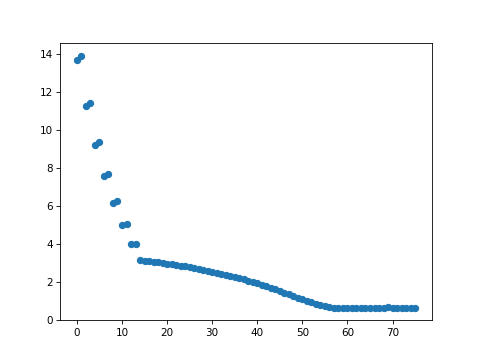

In [1867]:
plt.figure()
plt.scatter(np.arange(len(errors)), np.array(errors))

Same as above, but for "safekeeping".

In [1143]:
idx=1

bounds=[(0.7, 120.05)]

u = 'Car'
wl_a, wl_b = (480, 590)
Cab0 = 13.34
Car0 = Cab0/4

wavelengths, r, t = load_spectra(fpath, df, idx, dname=dname)
N, Ca, Cb, Cab, Car, Cw, Cm  = get_leaf_params(df, idx)
d = {'N': N, 'Cab': Cab, 'Car': Car, 'Cw': Cw, 'Cm': Cm}

print(Cab, Car)
print(err_fn(Cab, wavelengths, r+t, params))
errors = []


12.413689 3.65
2.6844939381521615


In [1268]:
print('Cab', Cab0, Cab)
u = 'Car'
params = {'N': N, 'Cw': Cw, 'Cab': Cab0, 'Car': Car0, 'unknown': u, 'Cm': Cm}
params.pop(u)

ans = minimize_fn(r, t, wavelengths, wl_a, wl_b, params, bounds=bounds, x0=Cab0)

Car0 = ans.x[0]
print('Car', Car0, Car)

u = 'Cab'
params = {'N': N, 'Cw': Cw, 'Cab': Cab0, 'Car': Car0, 'unknown': u, 'Cm': Cm}
params.pop(u)

ans = minimize_fn(r, t, wavelengths, wl_a, wl_b, params, bounds=bounds, x0=Car0)

Cab0 = ans.x[0]

error = err_fn(Cab0, wavelengths, r+t, params)
print(error)
errors.append(error)

Cab 23.12704821519571 12.413689
Car 7.29052462714961 3.65
4.433845794063673


In [ ]:
err_prev = 

In [404]:
print(err_fn(Cab0, wavelengths, r+t, params))

0.615922274980712


In [403]:
params

{'N': 1.504156011,
 'Cw': 0.01149099,
 'Car': 9.658908700847883,
 'unknown': 'Cab',
 'Cm': 0.0049338,
 'Cab': array([37.4190222])}

In [381]:
u = 'Cab'
params = {'N': N, 'Cw': Cw, 'Cab': Cab, 'Car': Car0, 'unknown': u, 'Cm': Cm}
params.pop(u)

ans = minimize_fn(r, t, wavelengths, wl_a, wl_b, params, bounds=bounds, x0=x0)

Cab0 = ans.x[0]
print(Cab0, Cab)

46.373527349445354 42.530861


In [380]:
params

{'N': 1.504156011,
 'Cw': 0.01149099,
 'Car': 12.27978083757078,
 'unknown': 'Cab',
 'Cm': 0.0049338,
 'Cab': array([46.37352736])}

In [ ]:
idx=55

u = 'Car'
wl_a, wl_b = (480, 590)
Cab0 = 23.34

wavelengths, r, t = load_spectra(fpath, df, idx, dname=dname)
N, Ca, Cb, Cab, Car, Cw, Cm  = get_leaf_params(df, idx)
d = {'N': N, 'Cab': Cab, 'Car': Car, 'Cw': Cw, 'Cm': Cm}

